# Eigenproblem for the transmon-resonator system

Author: G. P. Fedorov (gleb.fedorov@phystech.edu), https://github.com/vdrhtc/XMons

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [3]:
mpl.style.use('classic')

In [5]:
from scipy import *
from scipy.constants import e, h, hbar
from qutip import *

Capacitances and other parameters:

In [172]:
font = {"size":15}
matplotlib.rc("font", **font)

In [35]:
C_κ = 0e-15
C_g = 2e-15
C_q = 90e-15
res_factor = 1.7
C_r = 251.9e-15*res_factor
L_r = 9.737e-10*res_factor
Φ = 0 # in Φ_0
ν_q = 8.7
def C_ast():
    return sqrt(C_q*C_g+C_q*C_κ+C_g*C_κ+C_q*C_r+C_g*C_r)
def E_C():
    return (e)**2*(C_g+C_κ+C_r)/2/C_ast()**2/h/1e9
def E_J():
    return (ν_q*1e9+E_C()*1e9)**2/8/(e)**2/(C_g+C_κ+C_r)*2*C_ast()**2*h**2/h/1e9*cos(pi*Φ)
def ω_r():
    return 1/sqrt(L_r*C_ast()**2/(C_q+C_g))

In [30]:
E_J(), E_J()*h*1e9, E_J()/E_C(), ω_r()/1e9/2/pi, E_C()

(46.16175951424021,
 3.0587105171099199e-23,
 214.48162983179381,
 5.9778435067859244,
 0.21522477030057235)

In [31]:
N_q = 20
N_r = 5
n_g = 0

In [32]:
def a():
    return destroy(N_r)
def n():
    return Qobj((diag(arange(-N_q, N_q+1, 1))))

def H_q_isolated():
    H_q = 4*E_C()*n()**2+ E_J()/2*(Qobj(diag(ones(2*N_q), 1) + diag(ones(2*N_q), -1)))
    return H_q
def H_q():
    return tensor(identity(N_r), H_q_isolated())

def H_r():
    H_r = ω_r()/2/pi/1e9*(a().dag()*a()+1/2)
    return tensor(H_r, identity(2*N_q+1))
def g():
    return 2*e*C_g/C_ast()*sqrt(hbar*ω_r()/2/(C_q+C_g))/h/1e9
def H_i():
    return g()*1j*tensor(a().dag()-a(), n())
def H():
    return H_q()+H_r()+H_i()

In [11]:
Φ = 0
print(H().eigenenergies()[2]-H().eigenenergies()[0])

8.67634075915


In [126]:
Φ = 0
E_0 = H().eigenenergies()[0]
evals = []
Φs = linspace(-0.6, 0.6, 501)
for Φ in Φs:
    print("\rΦ:", Φ, flush=True, end="")
    evals.append(H().eigenenergies())
evals = array(evals)

Φ: -0.5184 -0.5352

KeyboardInterrupt: 

# Eigenenergies and eigenstates

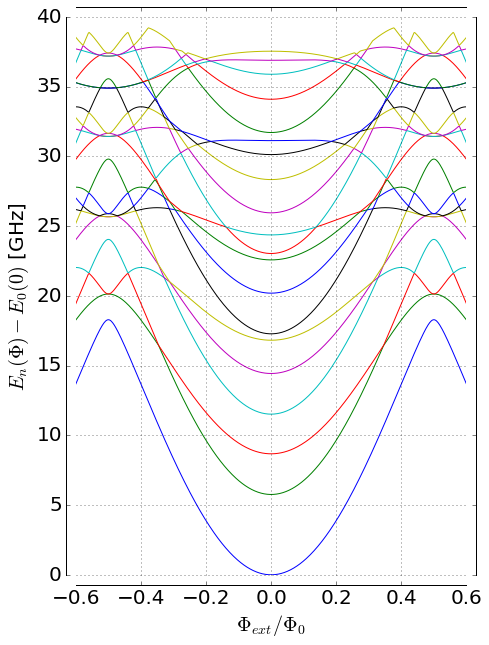

In [10]:
for i in range(0, 20):
    plt.plot(Φs, (evals[:, i]-E_0))
spines()
plt.ylabel("$E_n(\Phi) - E_0(0)$ [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.gcf().set_size_inches(7,10)
plt.grid()
plt.ylim(0,40)
plt.xlim(-0.6,0.6)

plt.savefig("levels.pdf",bbox_inches='tight')

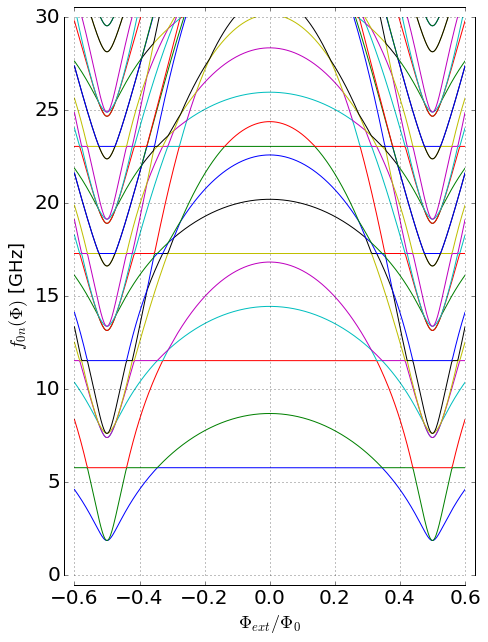

In [11]:
for i in range(1, 50):
    plt.plot(Φs, (evals[:, i]-evals[:,0]))
spines()
plt.xlim(-0.600,0.60)
plt.ylim(0, 30)

plt.ylabel("$f_{0n}(\Phi)$ [GHz]", fontsize=18)
plt.xlabel("$\Phi_{ext}/\Phi_0$", fontsize=18)
plt.xticks(linspace(-0.6, 0.6, 7))
plt.grid()
plt.gcf().set_size_inches(7,10)
plt.savefig("freqs.pdf", bbox_inches='tight')

# Energy diagram

In [212]:
Φ = 0
ν_q = 7
N_r = 10
nqs = range(0, 2*N_q+1, 1)
nrs = range(0, N_r, 1)
evecs = H().eigenstates()[1]
E_0 = H().eigenenergies()[0]
evecs_q = H_q_isolated().eigenstates()[1]
colors = ["b", "orange", "green", "red", "black"]

qubit_states_taken = 5

E_rs = zeros((N_r, qubit_states_taken))

for state in evecs:
    found = False
    for n_r in nrs:
        for n_q in nqs[:5]:
            base_vec = tensor(basis(N_r, n_r), evecs_q[n_q])
            if abs((state.dag()*base_vec).data[0,0]) > 0.5:
                E = (state.dag()*H()*state).data[0,0]
                E_rs[n_r, n_q] = real(E)
                #print(abs((state.dag()*base_vec).data[0,0]), n_r, n_q, E-E_0)

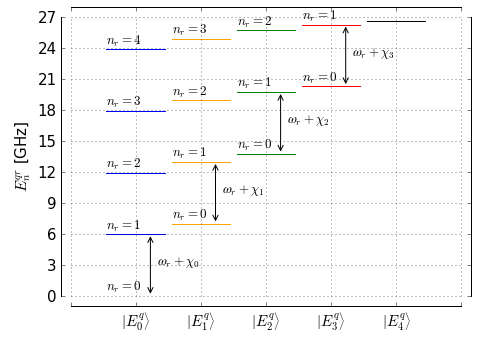

In [213]:
X = array([-0.45, 0.45])

for n_r in nrs:
    for n_q in nqs[:5]:
        plt.plot(X+n_q, np.around(ones_like(X)*E_rs[n_r, n_q] - E_0, 5), colors[n_q])
        plt.annotate("$n_r=%i$"%n_r, (X[0]+n_q, E_rs[n_r, n_q] - E_0+0.5),
                     (X[0]+n_q, E_rs[n_r, n_q] - E_0+0.5), fontsize=13)
        if n_r==1 and n_q<4:
            annotate_distance(plt.gca(), "$ω_r + \chi_%i$"%n_q, 
                              (n_q+X[-1]/2, E_rs[n_r-1, n_q] - E_0), (n_q+X[-1]/2, E_rs[n_r, n_q] - E_0), None, 13)
        
spines()
plt.gcf().set_size_inches(7, 5)
plt.xticks(linspace(-1, 5, 7))
plt.yticks(linspace(0, 27, 10))
plt.gca().set_xticklabels([""]+[r"$\left.|E^q_%i\right>$"%i for i in range(0,5)])
plt.ylabel("$E^{qr}_n$ [GHz]")
plt.grid()
plt.ylim(0, 27)

plt.savefig("diagram_q>r.pdf", format="pdf", bbox_inches="tight")

In [187]:
ν_q = 6.1
evals = []
soc_dispersive_shifts = []
Φs = linspace(-0.08, -0, 100)

for Φ in Φs:
    evals.append(H().eigenenergies())
    evals_q, evecs_q = H_q_isolated().eigenstates()
    evals_q = evals_q - evals_q[0]
    DS_for_Φ = [χ_0(), χ_1(), χ_2()]
    soc_dispersive_shifts.append(DS_for_Φ)
evals = array(evals)*1e3
soc_dispersive_shifts = array(soc_dispersive_shifts)*1e3
g()

0.022531416136266171

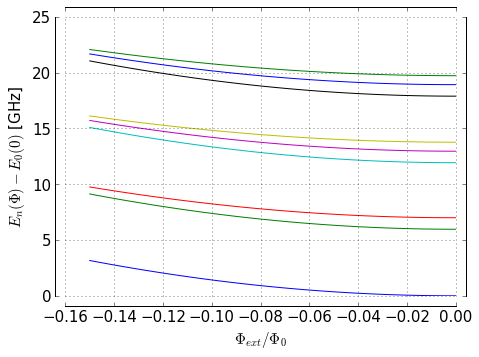

In [180]:
for i in range(0, 9):
    plt.plot(Φs, (evals[:, i] - evals[-1, 0])/1e3)
spines()
plt.ylabel("$E_n(\Phi) - E_0(0)$ [GHz]")
plt.xlabel("$\Phi_{ext}/\Phi_0$")
plt.gcf().set_size_inches(7,5)
plt.grid()

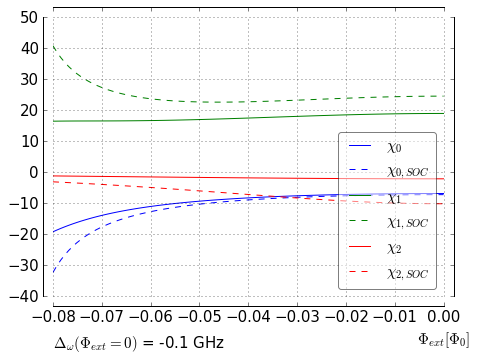

In [192]:
if ν_q - ω_r()/2/pi/1e9 > 0.2:
    plt.plot(Φs, evals[:, 1] - evals[:,0] -ω_r()/2/pi/1e6, label="$\chi_0$")
    plt.plot(Φs, soc_dispersive_shifts[:, 0], "b--", label="$\chi_{0, SOC} $") 
    plt.plot(Φs, evals[:, 4] - evals[:, 2] -ω_r()/2/pi/1e6, label="$\chi_1$")#-(evals[:, 1] - evals[:,0]))
    plt.plot(Φs, soc_dispersive_shifts[:, 1], "g--", label="$\chi_{1, SOC}$") 
    plt.plot(Φs, evals[:, 8] - evals[:,5] -ω_r()/2/pi/1e6, label="$\chi_2$")#-(evals[:, 1] - evals[:,0]))
    plt.plot(Φs, soc_dispersive_shifts[:, 2], "r--", label="$\chi_{2, SOC}$") 
elif 0 < ν_q - ω_r()/2/pi/1e9<0.2:
    plt.plot(Φs, evals[:, 1] - evals[:,0] -ω_r()/2/pi/1e6, label="$\chi_0$")
    plt.plot(Φs, soc_dispersive_shifts[:, 0], "b--", label="$\chi_{0, SOC} $") 
    plt.plot(Φs, evals[:, 5] - evals[:, 2] -ω_r()/2/pi/1e6, label="$\chi_1$")#-(evals[:, 1] - evals[:,0]))
    plt.plot(Φs, soc_dispersive_shifts[:, 1], "g--", label="$\chi_{1, SOC}$") 
    plt.plot(Φs, evals[:, 11] - evals[:,6] -ω_r()/2/pi/1e6, label="$\chi_2$")#-(evals[:, 1] - evals[:,0]))
    plt.plot(Φs, soc_dispersive_shifts[:, 2], "r--", label="$\chi_{2, SOC}$") 
else:
    plt.plot(Φs, evals[:, 2] - evals[:,0] -ω_r()/2/pi/1e6, label="$\chi_0$")
    plt.plot(Φs, soc_dispersive_shifts[:, 0], "b--", label="$\chi_{0, SOC}$") 
    plt.plot(Φs, evals[:, 4] - evals[:,1] -ω_r()/2/pi/1e6, label="$\chi_1$")#-(evals[:, 1] - evals[:,0]))
    plt.plot(Φs, soc_dispersive_shifts[:, 1], "g--", label="$\chi_{1, SOC}$") 
    plt.plot(Φs, evals[:, 7] - evals[:,3] -ω_r()/2/pi/1e6, label="$\chi_2$")#-(evals[:, 1] - evals[:,0]))
    plt.plot(Φs, soc_dispersive_shifts[:, 2], "r--", label="$\chi_{2, SOC}$") 

plt.gcf().set_size_inches(7, 5)
# plt.ylim(5.82, 5.84)
plt.xlim(Φs[0], 0)
plt.grid()

spines()
plt.legend(fancybox=True, framealpha=0.5, loc="lower right", fontsize=15)
plt.xlabel(r"$\Phi_{ext} [\Phi_0]$", position=(1,0))
# plt.ylabel("Shifts [MHz]")
plt.gca().annotate(r"$\Delta_\omega(\Phi_{ext}=0)$ = %.1f GHz"%(ω_r()/2/pi/1e9 - ν_q), 
                   (Φs[0], plt.gca().get_ylim()[0]), xytext=(0,-0.185),
                               textcoords="axes fraction")

plt.savefig("shifts%.0f.pdf"%(10*(ω_r()/2/pi/1e9 - ν_q)), bbox_inches="tight")

# Perturbation theory

In [193]:
Φ=0
ν_q = 6.1
evals_unpert, evecs_unpert = (H_q() + H_r()).eigenstates()
evals, evecs = (H_q() + H_r()+H_i()).eigenstates()
evals_q, evecs_q = H_q_isolated().eigenstates()
evals_q = evals_q - evals_q[0]

In [194]:
def second_order_correction_to(i, H_p, evals_unpert):
    return sum([abs(evecs_unpert[i].dag()*H_p*evecs_unpert[j])**2/
                (evals_unpert[i]-evals_unpert[j]) if j!=i else 0 for j in range(0, len(evals_unpert))])

In [195]:
N = 5
soc = second_order_correction_to(N, H_i(), (H_q() + H_r()).eigenenergies()[:])

In [196]:
soc.data[0], evals[N] - evals_unpert[N]

((0.031550287634198343+0j), 0.025601346253135482)

In [96]:
(second_order_correction_to(8, H_i(), (H_q() + H_r()).eigenenergies()[:]) -\
second_order_correction_to(5, H_i(), (H_q() + H_r()).eigenenergies()[:])).data[0]

(-0.002773250501970487+0j)

In [97]:
(abs(evecs_unpert[4].dag()*H_i()*evecs_unpert[12])**2/\
                (evals_unpert[4]-evals_unpert[12])).data[0]

(-0.00032024583872467015+0j)

In [98]:
(abs(evecs_unpert[2].dag()*H_i()*evecs_unpert[8])**2/\
                (evals_unpert[2]-evals_unpert[8])).data[0]

(-0.00016012291936233494+0j)

### Formulas testing

$\chi_0$:

In [99]:
evals[1] - evals[0] - ω_r()/2/pi/1e9

-0.001104225255274649

In [100]:
evals[2] - evals[0] - ω_r()/2/pi/1e9

1.030032058552881

In [101]:
(g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9-evals_q[1])\
+g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9-evals_q[1])).data[0],\
(g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9-evals_q[1])).data[0]

((-0.0011051716637515599+0j), (-0.001023857023430439+0j))

In [102]:
(g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9-evals_q[1])\
+g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9-evals_q[1])).data[0],\
(g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9-evals_q[1])).data[0]

((-0.0011051716637515599+0j), (-0.001023857023430439+0j))

In [146]:
def χ_0():
    return real((g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9-evals_q[1])\
        +g()**2*abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9-evals_q[1])).data[0])

$\chi_1$:

In [103]:
evals[4] - evals[1] - ω_r()/2/pi/1e9

1.0295444334289696

In [104]:
evals[4] - evals[2] - ω_r()/2/pi/1e9

-0.0015918503791860772

In [113]:
(evecs_q[1].dag()*n()*evecs_q[0])

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 1.44064653]]

In [122]:
g()**2*(abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9+evals_q[1])+\
abs(evecs_q[1].dag()*n()*evecs_q[2])**2/(ω_r()/2/pi/1e9+evals_q[1] - evals_q[2]) +\
abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9+evals_q[1]) + \
abs(evecs_q[1].dag()*n()*evecs_q[2])**2/(-ω_r()/2/pi/1e9+evals_q[1] - evals_q[2])).data[0], \
g()**2*(abs(evecs_q[1].dag()*n()*evecs_q[2])**2/(ω_r()/2/pi/1e9+evals_q[1] - evals_q[2]) \
        +abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9+evals_q[1])).data[0]

((-0.0015951706576611154+0j), (-0.0015163623786199011+0j))

In [124]:
-0.0015951706576611154 +0.0011051716637515599

-0.0004899989939095555

In [144]:
def χ_1():
    return real(g()**2*(abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(ω_r()/2/pi/1e9+evals_q[1])+\
        abs(evecs_q[1].dag()*n()*evecs_q[2])**2/(ω_r()/2/pi/1e9+evals_q[1] - evals_q[2]) +\
        abs(evecs_q[1].dag()*n()*evecs_q[0])**2/(-ω_r()/2/pi/1e9+evals_q[1]) + \
        abs(evecs_q[1].dag()*n()*evecs_q[2])**2/(-ω_r()/2/pi/1e9+evals_q[1] - evals_q[2])).data[0])

$\chi_2$:

In [48]:
evals[7] - evals[3] - ω_r()/2/pi/1e9

0.00028192182512754016

In [59]:
evals[8] - evals[5] - ω_r()/2/pi/1e9

-0.0079634719996324321

In [60]:
g()**2*((evecs_q[2].dag()*n()*evecs_q[1])**2/(ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
(evecs_q[2].dag()*n()*evecs_q[3])**2/(ω_r()/2/pi/1e9+evals_q[2] - evals_q[3]) +\
(evecs_q[2].dag()*n()*evecs_q[1])**2/(-ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
(evecs_q[2].dag()*n()*evecs_q[3])**2/(-ω_r()/2/pi/1e9+evals_q[2] - evals_q[3])).data[0,0],\
g()**2*((evecs_q[2].dag()*n()*evecs_q[3])**2/(ω_r()/2/pi/1e9+evals_q[2] - evals_q[3]) +\
(evecs_q[2].dag()*n()*evecs_q[1])**2/(-ω_r()/2/pi/1e9+evals_q[2]-evals_q[1])).data[0,0]

((-0.0081395969618212449+0j), (-0.0079952820072985951+0j))

In [49]:
g()**2*((evecs_q[2].dag()*n()*evecs_q[1])**2/(ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
(evecs_q[2].dag()*n()*evecs_q[3])**2/(ω_r()/2/pi/1e9+evals_q[2] - evals_q[3]) +\
(evecs_q[2].dag()*n()*evecs_q[1])**2/(-ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
(evecs_q[2].dag()*n()*evecs_q[3])**2/(-ω_r()/2/pi/1e9+evals_q[2] - evals_q[3])).data[0,0],\
g()**2*((evecs_q[2].dag()*n()*evecs_q[3])**2/(ω_r()/2/pi/1e9+evals_q[2] - evals_q[3]) +\
(evecs_q[2].dag()*n()*evecs_q[1])**2/(-ω_r()/2/pi/1e9+evals_q[2]-evals_q[1])).data[0,0]

((0.00028306790333129862+0j), (0.00040195453099995635+0j))

In [145]:
def χ_2():
    return real(g()**2*(abs(evecs_q[2].dag()*n()*evecs_q[1])**2/(ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
        abs(evecs_q[2].dag()*n()*evecs_q[3])**2/(ω_r()/2/pi/1e9+evals_q[2] - evals_q[3]) +\
        abs(evecs_q[2].dag()*n()*evecs_q[1])**2/(-ω_r()/2/pi/1e9+evals_q[2]-evals_q[1]) + \
        abs(evecs_q[2].dag()*n()*evecs_q[3])**2/(-ω_r()/2/pi/1e9+evals_q[2] - evals_q[3])).data[0])

# Cooper pair distribution in transmon eigenstates

In [273]:
Φ=0
# n_q = 10
colors = ["blue", "orange", "green", "red"]

n_states = [0,1,2,3] 
evals_q, evecs_q = H_q_isolated().eigenstates()
total_vals = []
ns_pairs = range(0, 2*N_q+1)
for n_state in n_states:
    vals = []
    for i in ns_pairs:
        vals.append(real((evecs_q[n_state].dag()*basis(2*N_q+1, i))[0,0]))
    total_vals.append(vals)

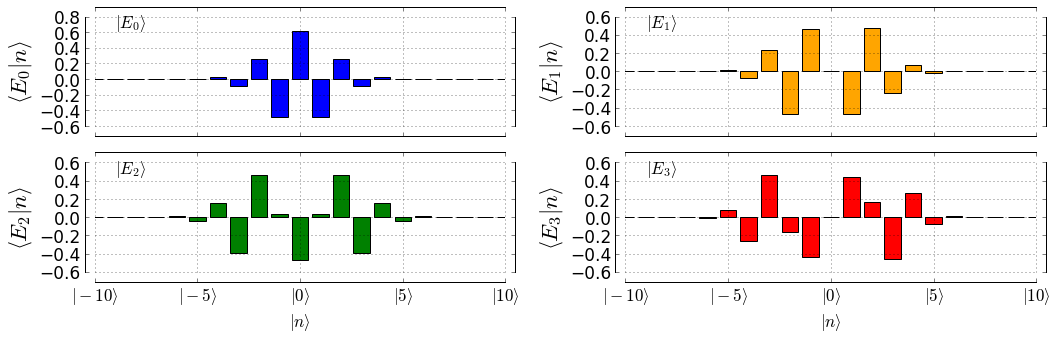

In [288]:
fig, axes = plt.subplots(2,2, figsize=(15,5))
axes = ravel(axes)
for idx, vals in enumerate(total_vals):
    axes[idx].bar(array(ns_pairs)-N_q-0.4, vals, color = colors[idx])
    axes[idx].grid()
    spines(axes[idx])
    axes[idx].annotate(r"$\left.| E_%i\right>$"%idx, (0,0), xytext=(0.05,0.9), textcoords="axes fraction")
    axes[idx].set_xlim(-10,10)
    axes[idx].set_ylabel(r"${\left< E_%i | n \right>}$"%idx, fontsize=23)

    if idx>1:
        axes[idx].set_xticklabels([r"$\left.| %i \right>$"%i for i in range(-n_q, n_q+1, 5)]);
        axes[idx].set_xlabel(r"${\left.|n\right>}$")
    else:
        axes[idx].set_xticklabels([""])
#plt.yticks(linspace(-0.5, 0.5, 11))
plt.tight_layout()
plt.savefig("tr_CPD.pdf", bbox_inches="tight")

In [253]:
state_ns = list(range(0, 11))

def get_mes(i):
    mes = []
    for j in state_ns:
        mes.append((evecs_q[i].dag()*n()*evecs_q[j]).data[0,0])
    return array(mes)

In [258]:
(evecs_q[0].dag()*n()*n()*evecs_q[2])

Quantum object: dims = [[1], [1]], shape = (1, 1), type = bra
Qobj data =
[[ 1.67883525]]

In [259]:
n_mat = []
for i in range(0, 11):
    n_mat.append(get_mes(i))
n_mat = array(n_mat)

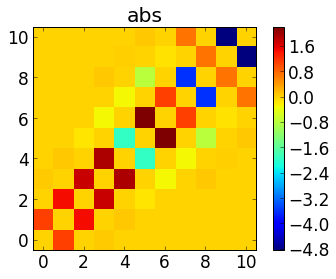

In [270]:
imshow(real(n_mat), origin="lower", interpolation="None")
colorbar()
title("abs")

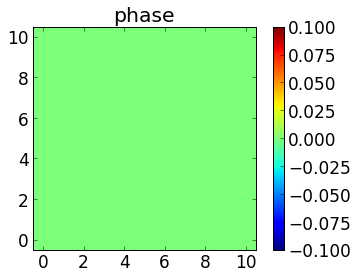

In [271]:
imshow(imag(n_mat), origin="lower", interpolation="None")
colorbar()
title("phase")

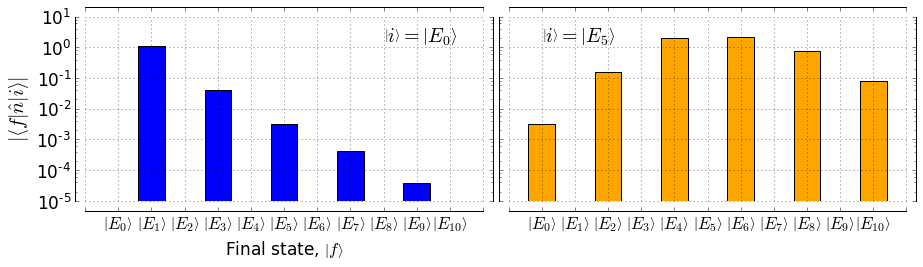

In [255]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(13,4))

axes[0].bar(array(state_ns)-0.4, abs(get_mes(0)), width=0.8, color="C0")
spines(axes[0])

axes[1].bar(array(state_ns)-0.4, abs(get_mes(5)), width=0.8, color="orange")
spines(axes[1])


for ax in axes:
    ax.grid()
    ax.set_yscale("log")
axes[1].set_yticklabels([])
axes[1].set_ylim(axes[0].get_ylim())
plt.gca().set_xticks([-1]+state_ns+[state_ns[-1]+1])
axes[0].set_xticklabels([""]+[r"$\left|E_{%i}\right>$"%n for n in state_ns])
plt.xlim(state_ns[0]-1, state_ns[-1]+1,15)
axes[0].set_ylabel(r"$|\left< f | \hat n | i \right>|$", fontsize=20)
axes[0].set_xlabel(r"Final state, $\left| f \right>$")
# axes[1].set_xlabel(r"Final state, $\left| f \right>$")
axes[0].annotate(r"$\left| i \right> = \left| E_0 \right>$", (8,1.5), fontsize=20)
axes[1].annotate(r"$\left| i \right> = \left| E_5 \right>$", (0,1.5), fontsize=20)
tight_layout(w_pad=1.5)
# plt.savefig("n_mes.pdf", bbox_inches="tight")

# $\hat n$ matrix elements

In [242]:
evecs_qs = []
ν_qs = linspace(6,6.5, 100)
for ν_q in ν_qs:
    evecs_qs.append(H_q_isolated().eigenstates()[1])

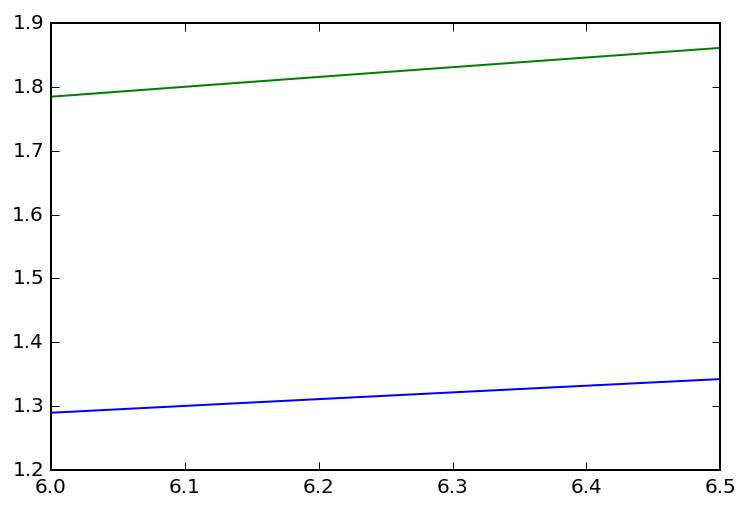

In [113]:
n01s = array([n().matrix_element(evecs_q[0], evecs_q[1]) for evecs_q in evecs_qs])
n12s = array([n().matrix_element(evecs_q[1], evecs_q[2]) for evecs_q in evecs_qs])
plt.plot(ν_qs, abs(n01s))
plt.plot(ν_qs, abs(n12s))

In [244]:
evecs_qs[0][0].dag()*n()*evecs_qs[0][0]

Quantum object: dims = [[1], [1]], shape = [1, 1], type = oper, isherm = True
Qobj data =
[[ 0.]]

In [36]:
text = "Life in a large city and in the countryside are very different from each other. Firstly, in the countryside unlike in the large city there is a small choice of profession and there is no opportunity to get a prestigious education. However, it is not a shortcoming for children and elderly people. Secondly, the rhythm of life is quieter in the countryside, there's no rush. People can relax and think about things they usually don't notice in the bustle of the city. In contrast in the large city there are many places for entertainment and cultural education. For example, museums, theaters and movie theaters, cafes, huge shopping centers and other various places for leisure or doing one's favourite hobby. Thirdly, insanely beautiful landscapes and untouched nature open to one's view in the countryside. It is also known there are fewer cars on the roads, less manufacturing, thus the air is cleaner there and the life is healthier in general. But in the large city there is a wide range of available products which are hardly accessible in the countryside and a well-developed transport network.  Frankly speaking in overall, there are positive and negative sides about each way of life and it may be the best to keep balance between both of them and if city people had more free time, may be they should spend some in the countryside."

word_count = 0
for word in text.split(" "):
    if len(word) > 3:
        word_count+=1
print(word_count)

135


In [9]:
Φs = linspace(-1,1, 100)
ν01s = 6*sqrt(abs(cos(pi*Φs)))

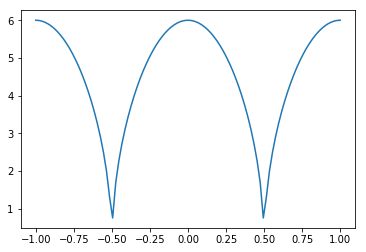

In [10]:
plt.plot(Φs, ν01s)

In [20]:
coeff = (78.5-32.5)/(78.5-9.7)

In [21]:
6.62/(sqrt(abs(cos(pi*coeff))))

9.3132032481244362